# Payoff strategies, risk, and the Central Limit Theorem

(This notebook was inspired by the question posted [here](https://brilliant.org/discussions/thread/which-payoff-do-you-want-to-go-for-2/).)

## Question

A coin with probability of landing heads $p$ is flipped $n$ times.
Beforehand, you choose whether you want a payout whenever
"HT" occurs vs when "HH" occurs (overlapping "substrings" count).
Which do you choose for $p = 0.5, n = 5$?

## Discussion of Solution

Of course, if $p > 0.5$ it intuitively makes sense to go with the $HH$ strategy. And in fact, one can verify that the expected payoffs favor the $HH$ strategy: $p > 0.5 \implies E[P_{HH}]>E[P_{HT}]$. This is done by breaking down the payoff random variable $P$ into indicator variables $X_j$, where $X_j$ indicates whether the substring of length $2$ starting at index $j$ of the string of tosses $S$ matches the chosen payoff strategy.

A similar argument can be made that if $p < 0.5$, the expected payoff criterion now favors $HT$ over $HH$. But what about when the coin is unbiased, i.e., $p =0.5$? 

Turns out, using the same sort of calculations via indicator variables, the expected payoff is the same for both strategies for $p = 0.5$. What about the variance of the payoffs? The calculation is a bit more involved (because we have to consider the dependence of adjacent indicator variables for the variance calculation), but it turns out that $Var(S_{HT}) < Var(S_{HH})$.

## Distribution of payoffs

The above inequalities made me start to wonder: what exactly do the distributions of these payoffs look like? One can set up a combinatorices problem to determine what
$Pr[\text{payoff} = j]$ is for $i \in \{0, 1, \cdots, n\}$ for either strategy.

This would be a good exercise, but sadly the expressions would likely not be particularly enlightening. It would take a bit of finessing to make expressions for arbitrary subsequence length (say, $HHT$ vs $HTH$).

To that end, I wrote up an R script to help visualize the differences between strategies of arbitrary length for coin toss sequences of length $n$ (by simulating a sequence of $n$ biased coin flips many times).

Let's take a look!

In [1]:
# the basic plumbing


library(plyr) # for mapvalues()
library(tidyverse)
library(tidyr)
library(tibble)


flip_fun <- function(n = 5, p = 0.5){
  # simulate sequence of n coin flips with bias p
  runif(n, min=0, max=1) > p
}

count_hits <- function(flips, match_seq)
{
  # count how many times the subsequence match_seq
  # occurs in flips
  # (both are boolean vectors)
  
  match_len = length(match_seq)
  iter_len = length(flips) - match_len + 1
  count <- 0
  for(i in 1:iter_len)
  {
    if(all(flips[i:(i+match_len-1)] == match_seq))
    {
      count <- count + 1
    }
  }
  count
}


# convert_to_str <- function(bool_vec){
#   # convert TRUE to "H" and FALSE to "T"
#   # return combined string version
#   bool_vec[bool_vec] = "H"
#   # now vector of strings
#   bool_vec[bool_vec == "FALSE"] = "T"
#   paste(bool_vec, collapse = '')
# }

convert_to_str <- function(bool_vec){
  # convert boolean vector to string of H's and T's
  
  # let's use plyr::mapvalues
  str_vec <- mapvalues(x = bool_vec, from = c(TRUE, FALSE), to = c("H", "T"))
  paste(str_vec, collapse = '')
}




Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.1       v purrr   0.3.2  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v readr   1.3.1       v forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::arrange()   masks plyr::arrange()
x purrr::compact()   masks plyr::compact()
x dplyr::count()     masks plyr::count()
x dplyr::failwith()  masks plyr::failwith()
x dplyr::filter()    masks stats::filter()
x dplyr::id()        masks plyr::id()
x dplyr::lag()       masks stats::lag()
x dplyr::mutate()    masks plyr::mutate()
x dplyr::rename()    masks plyr::rename()
x dplyr::summarise() masks plyr::summarise()
x dplyr::summarize() m

In [2]:
# actual experiment simulation code


simulate_experiment_1 <- function(match_seqs){

  # first need the df to have the proper number of rows
  # to be able to add columns
  df_res <- data_frame(runif(n = n_rep))
  
  # "lazy" way: have a separate set of simulations for each strategy
  # ("lazy" because simpler to code: use of "replicate()" per strategy)
  # but! higher time-complexity (#simulations = O(n_rep*n_strat) vs O(n_rep))
  # TODO: Make counts from same simulated string
  for (i in 1:length(match_seqs)){
    
    
    label <- convert_to_str(match_seqs[[i]])
    
    # first need to "initialize" column, then assign
    # as per 
    # https://stackoverflow.com/questions/29814912/error-replacement-has-x-rows-data-has-y
    
    df_res$i = NA
    df_res[i] <- replicate(n=n_rep, 
                          count_hits(flip_fun(num_flips, p = prob_heads),
                                     match_seq = match_seqs[[i]]
                                     )
                          )
    colnames(df_res)[i] <- label
  }
  
  df_res
  
  # we need to tidy up our dataframe --
  # -- currently, we have factors in separate columns/two observations per row!
  
  df_clean <- df_res %>% 
    gather(flip_type, payout, colnames(df_res))
  
  df_clean
}


# TODO: set up vectorization for speedup?
# though sadly, substring counting
# or dealing with matrix of repetitions are both a bit unwieldy...
simulate_experiment_2 <- function(match_seqs){
  # simulate the counting experiment, counting successes
  # for each seq in the list match_seqs
  
  # first need the df to have the proper number of rows
  # to be able to add columns
  df_res <- data_frame()
  

  
  # count per simulation and stick into df
  for (i in 1:n_rep){
    flips <- flip_fun(num_flips, prob_heads)
    temp_row <- c()
    for (j in 1:length(match_seqs)){
      temp_row <- c(temp_row, count_hits(flips, match_seq = match_seqs[[j]])
                    )
    }
    df_res <- rbind(df_res, temp_row)
  }
  
  # labels for df
  labels <- c()
  for (i in 1:length(match_seqs)){
    labels <- c(labels, convert_to_str(match_seqs[[i]]))
  }
  colnames(df_res) <- labels
  
  # we need to tidy up our dataframe --
  # -- currently, we have factors in separate columns/two observations per row!
  
  df_clean <- df_res %>% 
    gather(flip_type, payout, colnames(df_res))
  
  df_clean
}

# match_seqs <- list(
#   c(TRUE, FALSE, TRUE),
#   c(FALSE, TRUE, TRUE),
#   c(TRUE, TRUE, TRUE),
#   c(TRUE, TRUE, FALSE)
# )

# system.time(df_clean <- simulate_experiment_1(match_seqs))
# system.time(df_clean <- simulate_experiment_2(match_seqs))


# we choose (2) because, although it's slower,
# it compares how strategies did *on the same iteration*
simulate_experiment <- simulate_experiment_2








In [3]:
# visualization code

plot_strategies <- function(df_clean, plot_type = c()){
  # plot_type = "bar" or "density"
  
  # referring to http://www.cookbook-r.com/Graphs/Legends_(ggplot2)/
  # among other places for ggplot commands and other R commands
  
  caption_str <- stringr::str_wrap(
    paste(sprintf("Fractions obtained by performing %s simulations.", n_rep),
          sprintf("In each simulation, the coin was flipped %s times and had probability %.2f of landing heads.", num_flips, prob_heads)
          #,sep = "\n" #str_wrap overrides internal whitespace
    )
    , width = 100)
  
  caption_str
  
  if (length(plot_type) == 0){
    # some heuristics
    if (num_flips < 50){
      plot_type <- "bar"
    }
    else {
      plot_type <- "density"
    }
  }
  
  if (plot_type == "bar"){
  ggplot(df_clean, aes(x = payout, fill = flip_type)) + 
    geom_bar(aes(y = (..count..)/sum(..count..)), position = position_dodge(preserve = "total"), 
             colour = "black") +
    scale_fill_discrete(name="Strategy", c=50, l = 50) +
    ggtitle("Comparison of decision strategies") +
    labs(x= "Payout", y = "Fraction of Outcomes",
         caption = caption_str)
    }
  else if (plot_type == "density"){
    ggplot(df_clean, aes(x = payout, fill = flip_type)) + 
      geom_density(aes(y = (..count..)/sum(..count..)), 
               colour = "black", alpha = 0.4) +
      scale_fill_discrete(name="Strategy", c=50, l = 50) +
      ggtitle("Comparison of decision strategies") +
      labs(x= "Payout", y = "Fraction of Outcomes",
           caption = caption_str)
  }
}



OK, we've done pretty much all the code-plumbing we need to actually carry out the simulations now. Let's look at some graphs!

Specifically, let's see what the distribution for our alternative strategies would be (i.e., $n = 5, p = 0.5, \text{strategies} = \{HH, HT\}$).

Warning message:
"`data_frame()` is deprecated, use `tibble()`.
This warning is displayed once per session."The following `from` values were not present in `x`: FALSE


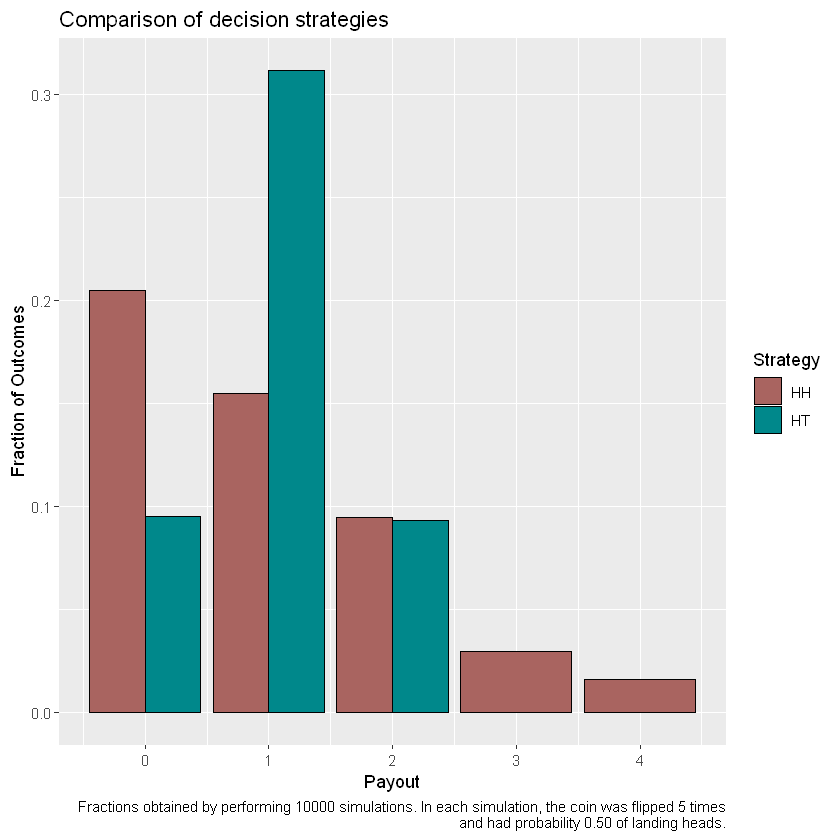

In [4]:
n_rep <- 10000 # should be enough simulations to get a pretty solid estimates


num_flips <- 5
prob_heads <- 0.5

match_seqs <- list(
  c(TRUE, TRUE),
  c(TRUE, FALSE)
)

plot_strategies(simulate_experiment(match_seqs))

Ah, the difference is quite stark!

We can use Markov chains as a visual aid for why $HT$ ought to have lower variance than $HH$.

In [52]:
# install.packages("markovchain")

In [7]:
library(markovchain)

Package:  markovchain
Version:  0.6.9.14
Date:     2019-01-20
BugReport: http://github.com/spedygiorgio/markovchain/issues



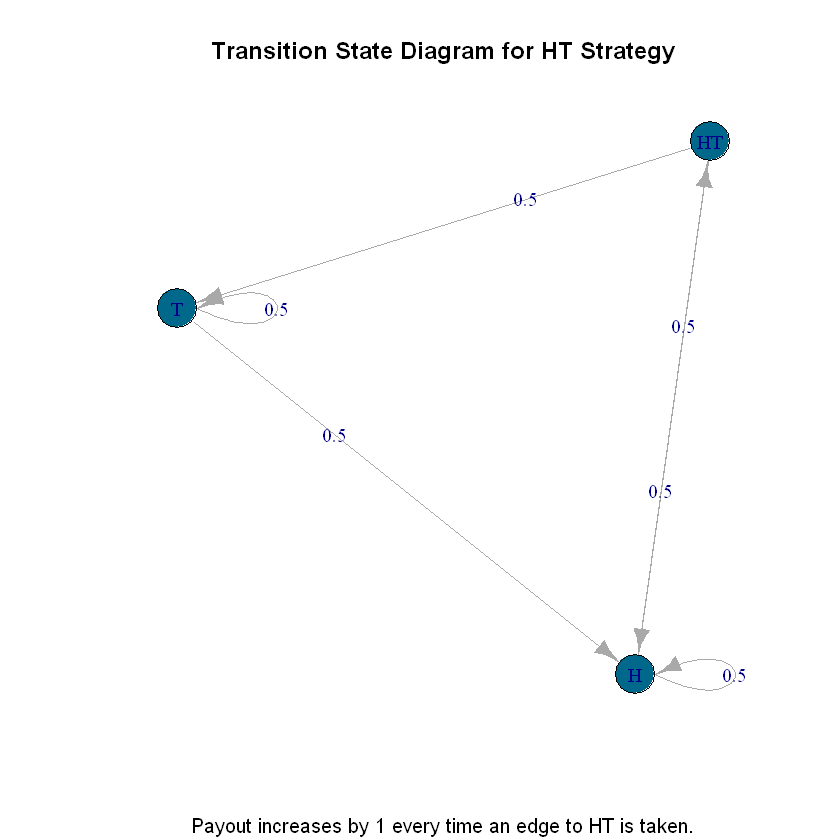

In [14]:
mc_HT <- new("markovchain", states = c("T", "H", "HT"),
             transitionMatrix = matrix(data = c(0.5, 0.5, 0.0,
                                                0.0, 0.5, 0.5,
                                                0.5, 0.5, 0.0), 
                                       byrow = TRUE, 
                                       nrow = 3),
             name = "HT Strategy")
plot(mc_HT,
     main = sprintf("Transition State Diagram for %s", name(mc_HT)),
     sub = "Payout increases by 1 every time an edge to HT is taken."
)

For the $HT$ strategy, there is no way to "lose progress" toward the desired state $HT$. Once you have an $H$, you either stay at $H$ (if another "heads" pops up) or move forward to the reward state $HT$ (if a tails is flipped).

The tradeoff for this "ensured progress" is that once you reach the reward state, you have to be sent back to an earlier state.

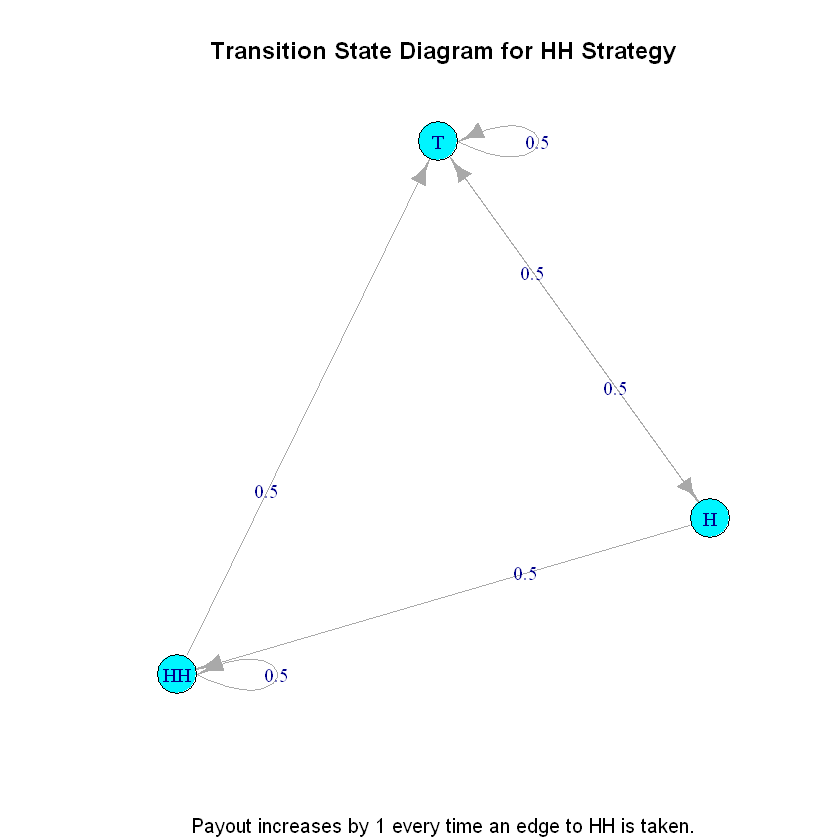

In [33]:
mc_HH <- new("markovchain", states = c("T", "H", "HH"),
                          transitionMatrix = matrix(data = c(0.5, 0.5, 0.0,
                                                              0.5, 0.0, 0.5,
                                                              0.5, 0.0, 0.5), 
                                                    byrow = TRUE, 
                                                    nrow = 3),
                          name = "HH Strategy")
plot(mc_HH,
     main = sprintf("Transition State Diagram for %s", name(mc_HH)),
     sub = "Payout increases by 1 every time an edge to HH is taken."
)

For the $HH$ strategy, one *needs* at least two favorable outcomes in a row for there to be any payoff -- one $T$ resets progress completely.

In exchange for this riskier setup, one gets the possibility of stringing together many rewards in a row (via a long string of $H$'s).

That explains the original problem. But we went through so much effort to make the simulation extensible -- let's see what happens for other situations!

First, let's look at simply increasing the number of flips to, say, 30.

The following `from` values were not present in `x`: FALSE


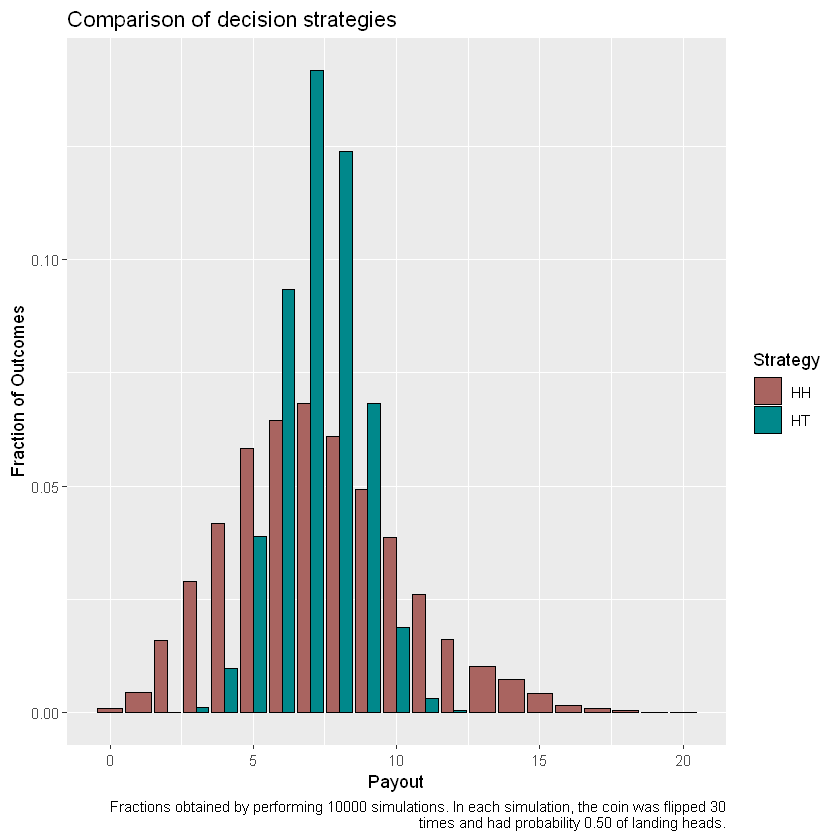

In [37]:
n_rep <- 10000 # should be enough simulations to get a pretty solid estimates


num_flips <- 30


plot_strategies(simulate_experiment(match_seqs), plot_type = 'bar')

Interesting -- the $HH$ strategy is far less lop-sided than it used to be, but still has a noticeable right-tail. We'll comment on that more in a bit -- first, let's try some other strategies.

The following `from` values were not present in `x`: FALSE


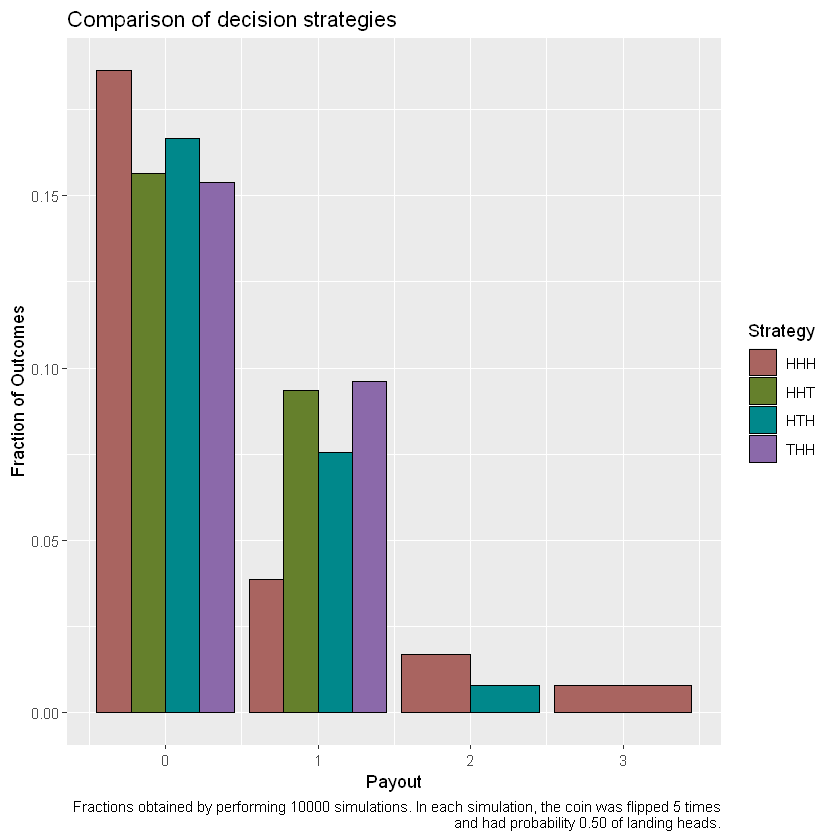

In [51]:
num_flips <- 5
match_seqs <- list(
  c(TRUE, FALSE, TRUE),
  c(FALSE, TRUE, TRUE),
  c(TRUE, TRUE, TRUE),
  c(TRUE, TRUE, FALSE)
)


plot_strategies(simulate_experiment(match_seqs), plot_type = 'bar')

It looks as if $THH$ and $HHT$ would be the choices you'd want if you want to maximize the probability of leaving the game with at least some payout, $HHH$ is aiming for maximum payout, and $HTH$ is a strategy inb etween the two extremes. Let's increase the number of flips to $n = 30$ and see how things look.

The following `from` values were not present in `x`: FALSE


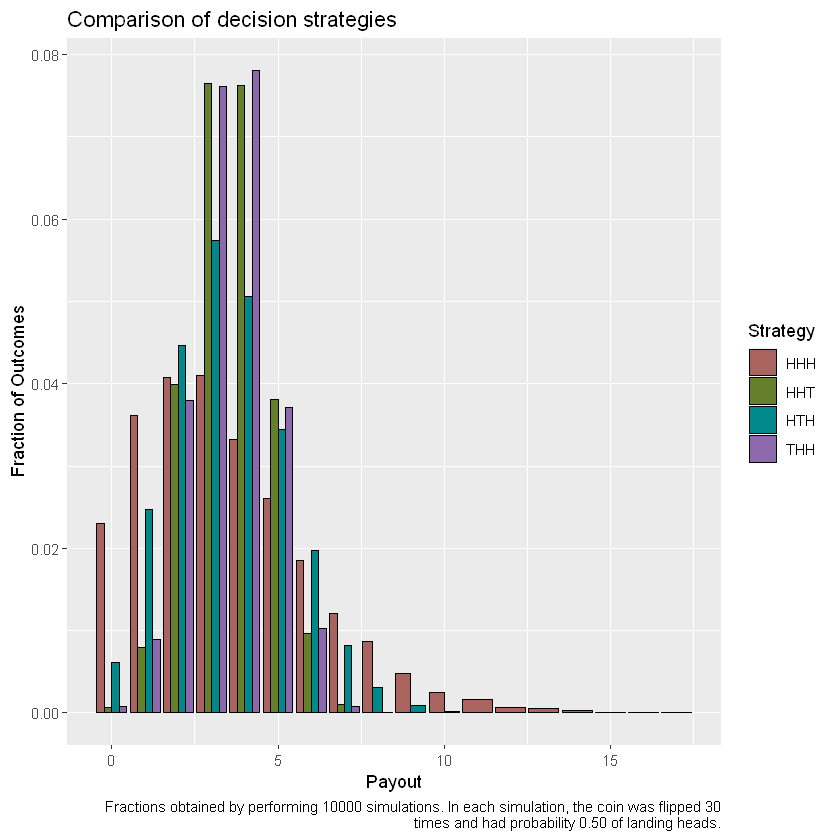

In [42]:
#
# Actual code
#
num_flips <- 30
match_seqs <- list(
  c(TRUE, FALSE, TRUE),
  c(FALSE, TRUE, TRUE),
  c(TRUE, TRUE, TRUE),
  c(TRUE, TRUE, FALSE)
)


plot_strategies(simulate_experiment(match_seqs), plot_type = 'bar')

The $HHT$ and $THH$ strategies mirror each other rather closely, as they both have roughly the same amount of "hedging". The $HTH$ strategy has slightly less hedging, aiming for possible overlapping substrings (e.g. $HTHTH$, netting a reward of $2$ in a substring of length only $5$ rather than $6$), leading to higher variance. The riskiest of all strategies remains the "all heads" $HHH$ strategy, leaving a long right tail.

Alright, these were for relatively short sequences of coin flips. Let's see what happens to our original two strategies after a ton of coin flips -- say, $n = 500$.

The following `from` values were not present in `x`: FALSE


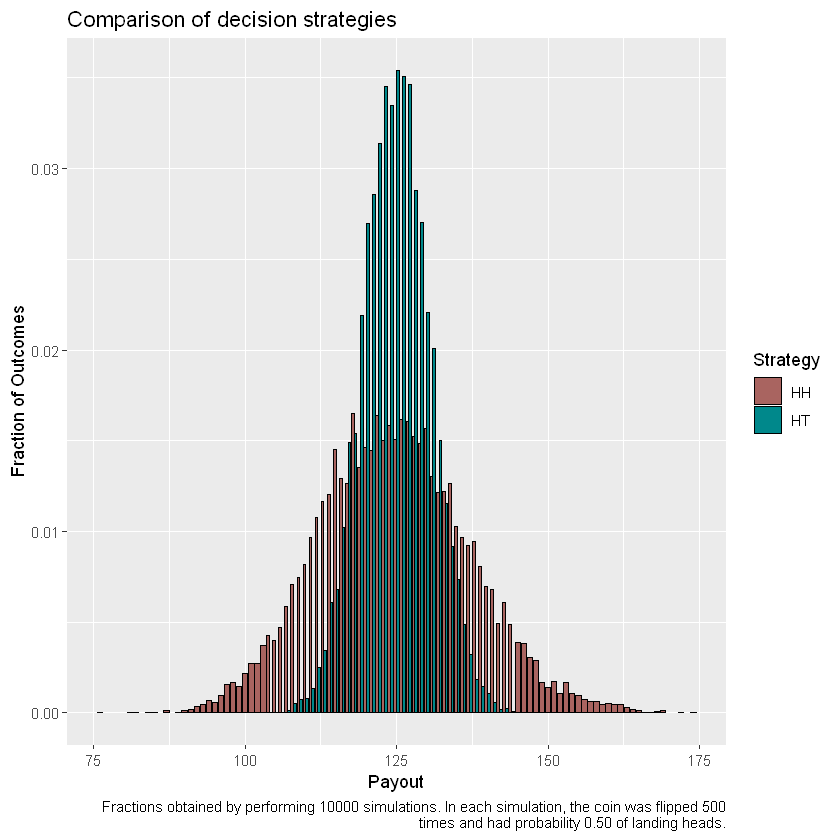

In [45]:
num_flips <- 500
prob_heads <- 0.5

match_seqs <- list(
  c(TRUE, TRUE),
  c(TRUE, FALSE)
)

df_clean <- simulate_experiment(match_seqs)
plot_strategies(df_clean, plot_type = 'bar')

The barplot might be a little messy to look at -- we'll smooth it out with a kernel density estimate.

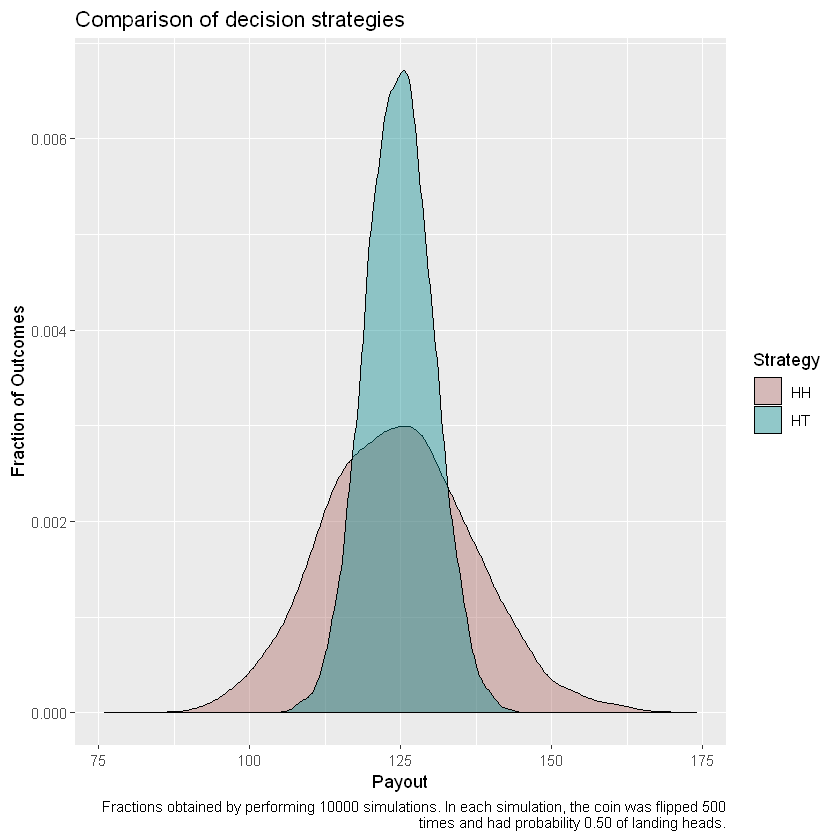

In [47]:
plot_strategies(df_clean, plot_type = 'density')

Those look awfully bell-shaped! Let's see if this also happens for our more complicated strategies:

The following `from` values were not present in `x`: FALSE


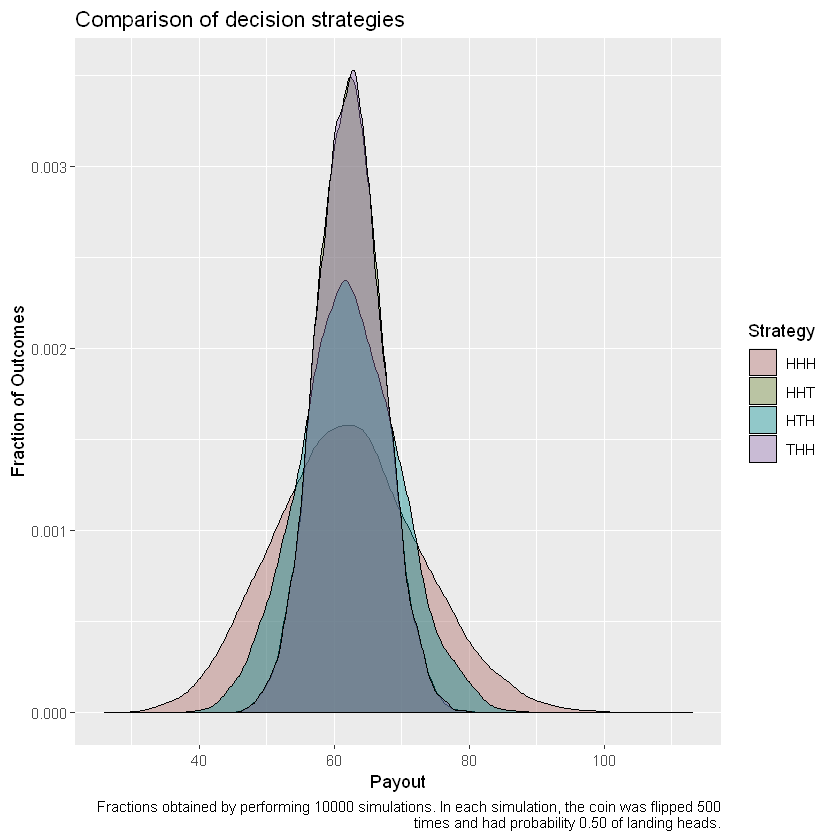

In [50]:
match_seqs <- list(
  c(TRUE, FALSE, TRUE),
  c(FALSE, TRUE, TRUE),
  c(TRUE, TRUE, TRUE),
  c(TRUE, TRUE, FALSE)
)

df_clean <- simulate_experiment(match_seqs)
plot_strategies(df_clean)

Yup, pretty bell-shaped! They are all centered around the same value, but they are spread by different amounts. The riskiest strategy ($HHH$) has the most spread, followed by $HTH$, while $THH$ and $HHT$ essentially perfectly overlap.

What's going on here? Well, we said before that we can break down the payoff $P$ into a sum of indicator variables, more specifically:

$$P_n = \sum_{i=1}^{n-k + 1}X_{i;S,k}$$

where $X_{i;S,k}$ is an indicator variable determining whether the substring of $P_n$ starting at index $i$ matches the substring $S$, which has length $k$.

Note that "nearby" $X_i$'s are dependent on one another! This corresponds to the fact that the substrings they are looking at overlap. However, $|j-i|>k \implies X_i \text{ and } X_j \text{ are independent}$; i.e., indicator variables far enough away from each other are independent. And $P_n$ is the sum of many copies of these indicator variables. Subsets of these indicator variables are pairwise independent, but as $n$ increases, the number of pairwise independent subsets are dwarfed by the many, many subsets of *independent* indicator random variables.

This makes $P_n$ "look" more and more like a sum of independent, identically distributed random variables. And what does that mean? The Central Limit Theorem! And indeed, as $n$ grows larger and larger, the resulting distribution becomes arbitrarily close to a Gaussian with the same mean and variance as the underlying sum of random variables.

But note how large of a difference there is between the distribution of our strategies for $n = 5$ compared to $n = 500$. If we know we'll be in the realm of asymptotic statistics, we are lucky to usually be able to invoke the Central Limit Theorem and simplify our analysis. But we have no such luck when $n = 5$, where simply stating expectations and variances may not provide a full enough picture of the underlying probability mass function. Another example of why it's always important to pay attention to the situation under consideration!

\- DK, 6/17/2019